In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import cartopy.feature as cfeature
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import matplotlib.pyplot as plt
import time
import importlib
import stormcoupling as sc
import glob
from scipy import stats
import scipy
from geopy import distance
from scipy import interpolate
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import cm
import xlrd
import csv
import os
import math
import matplotlib.colors
import metpy
from metpy.interpolate import interpolate_to_isosurface
from metpy.calc import dewpoint_from_specific_humidity
from metpy.calc import equivalent_potential_temperature
from matplotlib.ticker import LogFormatterSciNotation
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from metpy.units import units 
import metpy.calc as mpcalc
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import imageio.v2 as imageio
from PIL import Image, ImageOps
importlib.reload(sc)

<module 'stormcoupling' from '/lustre06/project/6084782/shared/gabe-fall-2025/TEtracking/stormcoupling.py'>

In [2]:
#### takes output data from StitchNodes (tracks) and organizes it into datafram with individual track IDs

def parse_te_tracks(filename):
    tracks = []
    trackid = -1
    with open(filename) as f:
        current_id = None
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            if parts[0] == "start":
                length = int(parts[1])  # track ID
                trackid = trackid+1
            else:
                lon, lat, msl, year, month, day, hour = parts[-7:]
                tracks.append({
                    "id": trackid,
                    "length": length,
                    "lon": float(lon),
                    "lat": float(lat),
                    "msl": float(msl),
                    "time": pd.Timestamp(int(year), int(month), int(day), int(hour))
                })
    return pd.DataFrame(tracks)

In [5]:
tracks_1 = parse_te_tracks('data/TEtextfiles/StitchNodes/NH/cyclone_SN_msl.txt')

In [16]:
tracks_1

,id,length,lon,lat,msl,time
0,0,25,148.25,38.75,98397.69,2015-01-01 00:00:00
1,0,25,150.75,39.75,97786.81,2015-01-01 03:00:00
2,0,25,152.00,40.50,97345.12,2015-01-01 06:00:00
3,0,25,153.25,41.00,96832.44,2015-01-01 09:00:00
4,0,25,155.25,41.50,96460.12,2015-01-01 12:00:00
...,...,...,...,...,...,...
3423,171,11,111.25,45.25,99447.69,2015-04-30 09:00:00
3424,171,11,112.50,45.50,99562.12,2015-04-30 12:00:00
3425,171,11,116.25,45.50,99708.88,2015-04-30 15:00:00
3426,171,11,117.25,47.00,99604.31,2015-04-30 18:00:00


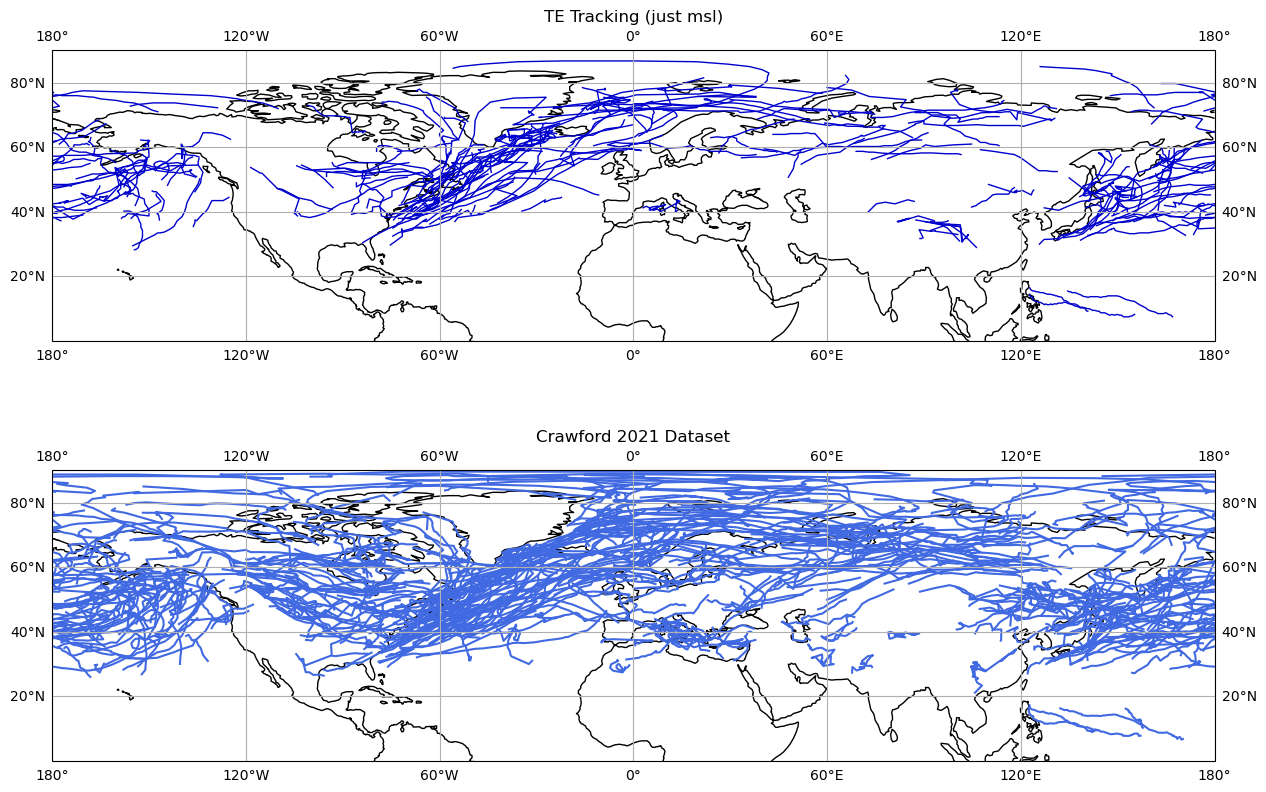

In [9]:
defaultSYN = '/home/glach/projects/def-rfajber/shared/tracks-gabe/SYN_Tracks.csv'
syns = pd.read_csv(defaultSYN)

fig, axes = plt.subplots(
    nrows=2, ncols=1,
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(15, 10)
)
axes[0].coastlines()
axes[0].gridlines(draw_labels=True)
axes[1].coastlines()
axes[1].gridlines(draw_labels=True)

# Plot each cyclone track
for tid, track in tracks_1.groupby("id"):
    axes[0].plot(track["lon"], track["lat"], linewidth=1, transform=ccrs.Geodetic(), c='mediumblue')
for path in syns.path:
    syn = pd.read_csv(path)
    if(syn.year[0] == 2015):
        month = int(syn.month[0])
        if(1 <= month <= 4):
            #print('hi')
            axes[1].plot(syn.lon, syn.lat, c='royalblue', transform=ccrs.Geodetic())
    
axes[0].set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
axes[1].set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
axes[0].set_title('TE Tracking (just msl)')
axes[1].set_title('Crawford 2021 Dataset')
#plt.savefig('test.jpg', bbox_inches='tight')
plt.show()

In [10]:
tracks_2 = parse_te_tracks('data/TEtextfiles/StitchNodes/NH/cyclone_SN_msl_200.txt')

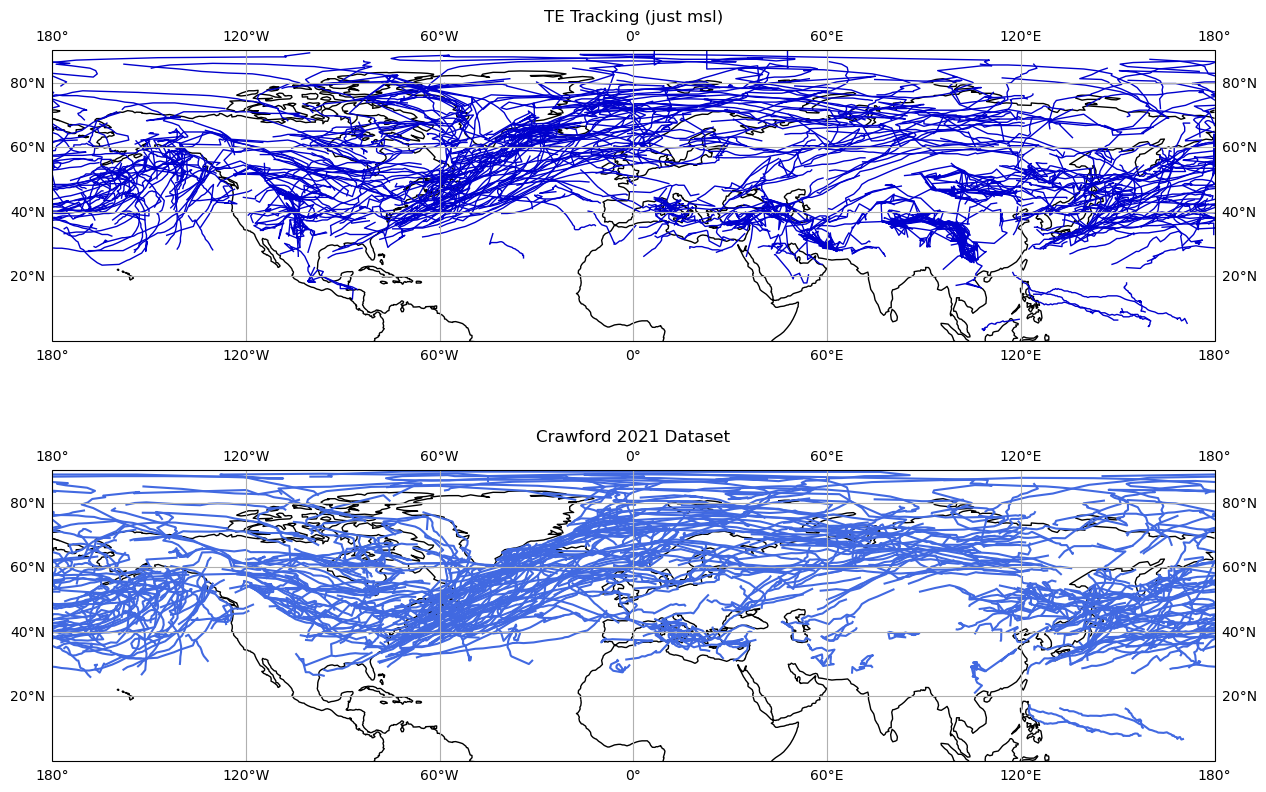

In [11]:
defaultSYN = '/home/glach/projects/def-rfajber/shared/tracks-gabe/SYN_Tracks.csv'
syns = pd.read_csv(defaultSYN)

fig, axes = plt.subplots(
    nrows=2, ncols=1,
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(15, 10)
)
axes[0].coastlines()
axes[0].gridlines(draw_labels=True)
axes[1].coastlines()
axes[1].gridlines(draw_labels=True)

# Plot each cyclone track
for tid, track in tracks_2.groupby("id"):
    axes[0].plot(track["lon"], track["lat"], linewidth=1, transform=ccrs.Geodetic(), c='mediumblue')
for path in syns.path:
    syn = pd.read_csv(path)
    if(syn.year[0] == 2015):
        month = int(syn.month[0])
        if(1 <= month <= 4):
            #print('hi')
            axes[1].plot(syn.lon, syn.lat, c='royalblue', transform=ccrs.Geodetic())
    
axes[0].set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
axes[1].set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
axes[0].set_title('TE Tracking (just msl)')
axes[1].set_title('Crawford 2021 Dataset')
#plt.savefig('test.jpg', bbox_inches='tight')
plt.show()

In [13]:
a = xr.open_dataset('/home/glach/projects/def-rfajber/shared/gabe-fall-2025/TEtracking/data/era5-raw/NH/t_850.nc')

In [14]:
a

<xarray.Dataset> Size: 2GB
Dimensions:         (valid_time: 960, pressure_level: 1, latitude: 361,
                     longitude: 1440)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 8kB 2015-01-01 ... 2015-04-30...
  * pressure_level  (pressure_level) float64 8B 850.0
  * latitude        (latitude) float64 3kB 90.0 89.75 89.5 ... 0.5 0.25 0.0
  * longitude       (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    expver          (valid_time) <U4 15kB ...
Data variables:
    t               (valid_time, pressure_level, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-25T19:07 GRIB to CDM+CF via cfgrib-0.9.1...

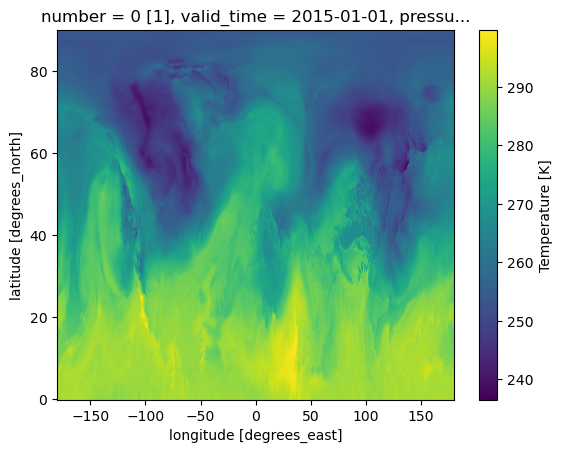

In [15]:
a.isel(valid_time=0).t.plot()